# CS448 - Lab 6: Denoising

In this lab we will use denoising to clean up some noisy recordings. We will use the following sounds:

Speech in a room: [https://drive.google.com/uc?export=download&id=1g5nbBpNbCjqs8cSoW0Lb-owe15tswDwW ]

ATC: [https://drive.google.com/uc?export=download&id=1fh5iL5qRj3-PUP_sG5-QE5DofACY_Hr5 ]

Speech with wind: [https://drive.google.com/uc?export=download&id=1g7TIkLpnWDFNUQYgCqIUoSOkk5EIK16_ ]



In [1]:
### IMPORTS & SETUP ###

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6, 3)

import numpy as np
from scipy.io import wavfile
from scipy.signal import medfilt2d

import warnings

DRAW_GRAPHS = True

In [2]:
### UTILITIES ###


# Sound player function that plays array "x" with a sample rate "rate", and labels it with "label"
def sound(x, rate=8000, label=''):
    from IPython.display import display, Audio, HTML
    display(
        HTML('<style> table, th, td {border: 0px; }</style> <table><tr><td>' +
             label + '</td><td>' + Audio(x, rate=rate)._repr_html_()[3:] +
             '</td></tr></table>'))


# Function that normalizes a signal
def normalize_signal(x):
    return x / np.max(np.abs(x))


def plot_stft(stft, fs, title=""):
    output = np.absolute(stft)**0.3
    time = np.linspace(0, output.shape[0] * HOP_SIZE / fs, output.shape[0])
    freq = np.linspace(0, fs / 2, int((DFT_SIZE + ZERO_PAD) / 2 + 1))
    plt.pcolormesh(time, freq, output.T)
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (HZ)")
    plt.title(title)
    plt.show()

In [3]:
# STFT from Lab 1
def stft(input_sound, dft_size, hop_size, zero_pad, window):
    # Creating the n-1 frames
    frames = []
    idx = 0
    for idx in range(0, len(input_sound) - dft_size, hop_size):
        frames.append(np.multiply(input_sound[idx:idx + dft_size], window))
    idx += hop_size

    # Creating the last frame accounting for padding
    last_frame = np.multiply(
        np.append(input_sound[idx:-1],
                  np.zeros(idx + dft_size - len(input_sound) + 1)), window)
    frames.append(last_frame)

    # Convert to numpy array
    frames = np.array(frames, dtype=float)

    # Compute the DFT of each frame
    dft_frames = np.fft.rfft(frames, dft_size + zero_pad)
    return dft_frames


# ISTFT from Lab 1
def istft(stft_output, dft_size, hop_size, zero_pad):
    # Initializing the signal length
    signal_length = (stft_output.shape[0] * hop_size) + dft_size + zero_pad
    signal = np.zeros(signal_length)

    for i in range(stft_output.shape[0]):
        original_signal = np.fft.irfft(stft_output[i, :], dft_size + zero_pad)
        start = i * hop_size
        end = start + original_signal.shape[0]
        signal[start:end] += original_signal

    return signal


# STFT parameters
DFT_SIZE = 512
HOP_SIZE = DFT_SIZE // 4
ZERO_PAD = 0
WINDOW = np.hanning(DFT_SIZE)

## Part 1. Cleaning up the sounds

Let’s start by cleaning up these sounds as best as we can. We will do a straightforward magnitude spectral subtraction. For all of these sounds there is only noise in the first few seconds of the recording so that you can learn a noise profile from there. Do the following:
Perform an STFT of the recordings

- Estimate the magnitude spectrum of the noise from the beginning of the recording
    - It’s up to you to figure out how many seconds to use (hint: look at the spectrogram)

- Perform spectral subtraction by subtracting that spectrum from the input’s magnitude STFT
    - Remember to clip any resulting negative values to zero
    - Try to find how much of the noise to subtract so that the output looks good

- Use the original signal’s phase to convert back to a time series.

Make a note of which examples sound the best and are easier to work with. Try to explain why.
At this point some of the outputs will exhibit “musical noise”. To minimize its effects apply a median filter on the denoised magnitude spectrogram to make it sound better (hint: ```scipy.signal.medfilt2```). How big should the median window be? Try different values and find which work best.


In [4]:
# Denoises an input signal using the noise signal
def denoise(input_stft, noise, fs, reduction_factor, fname="file"):
    # Estimate the magnitude spectrum of the noise
    noise_stft = stft(noise, DFT_SIZE, HOP_SIZE, ZERO_PAD, WINDOW)
    noise_mag = np.abs(noise_stft)
    noise_mean_mag = np.mean(noise_mag, axis=0, keepdims=True)

    # Estimate the magnitude spectrum of the input
    input_mag = np.abs(input_stft)
    phase = input_stft / input_mag

    # Denoise the input
    denoised = input_mag - (reduction_factor * noise_mean_mag)
    denoised.clip(min=0, out=denoised)

    # Reconstruct the signal
    denoised_stft = denoised * phase
    denoised_sound = istft(denoised_stft, DFT_SIZE, HOP_SIZE, ZERO_PAD)

    sound(denoised_sound, fs, f"{fname} denoised")
    if DRAW_GRAPHS:
        plot_stft(denoised, fs, f"{fname} denoised Spectrogram")

    # Filtering the denoised signal
    filtered_stft = medfilt2d(np.abs(denoised), 3)
    filtered_sound = istft(filtered_stft * phase, DFT_SIZE, HOP_SIZE, ZERO_PAD)

    sound(filtered_sound, fs, f"{fname} denoised and filtered")
    if DRAW_GRAPHS:
        plot_stft(filtered_stft, fs, f"{fname} denoised and filtered Spectrogram")

    # I found that the filter helped with removing the artifacts however it was
    # not able to do a perfect job. When I put the value as 5, the filter seemed to extreme,
    # and as you cannot use even numbers, I landed up on a value of 3.

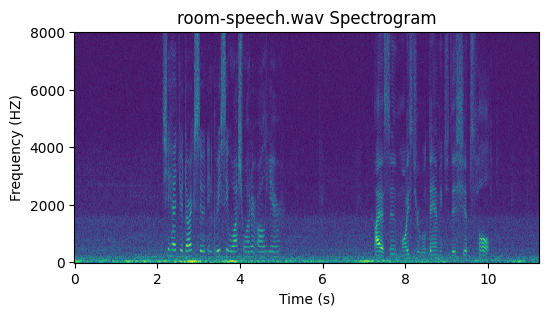

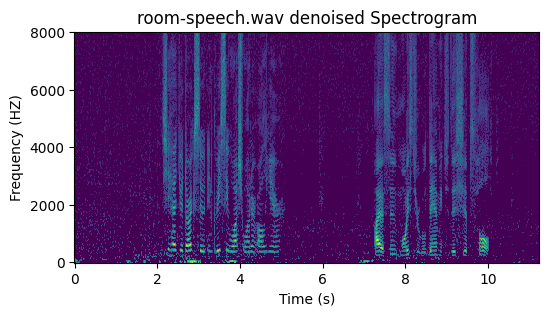

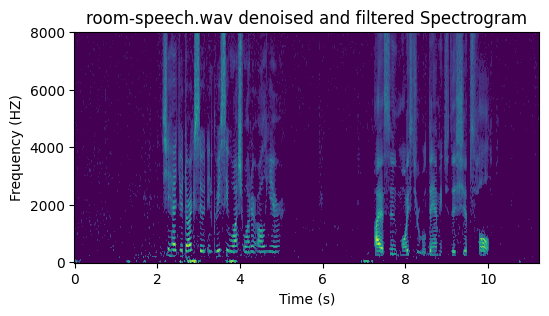

In [5]:
# Working on the room-speech.wav file
fname_room = 'room-speech.wav'

fs_room, input_room = wavfile.read(f'./data/{fname_room}')
input_room = normalize_signal(input_room)
sound(input_room, fs_room, fname_room)

stft_room = stft(input_room, DFT_SIZE, HOP_SIZE, ZERO_PAD, WINDOW)
if DRAW_GRAPHS:
    plot_stft(stft_room, fs_room, f"{fname_room} Spectrogram")

## The noise in this file is very prominent from 0 to 2 seconds. ##

# Isolating the noise
noise = input_room[0:2 * fs_room]
sound(noise, fs_room, f"Noise in {fname_room}")
denoise(stft_room, noise, fs_room, 1.6, fname_room)

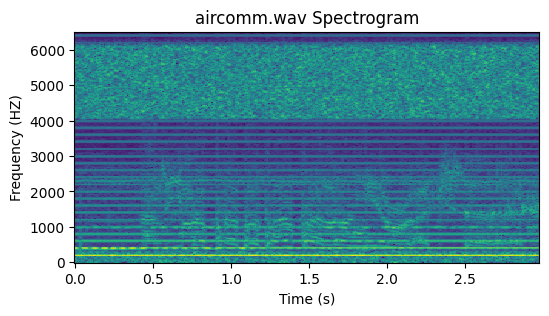

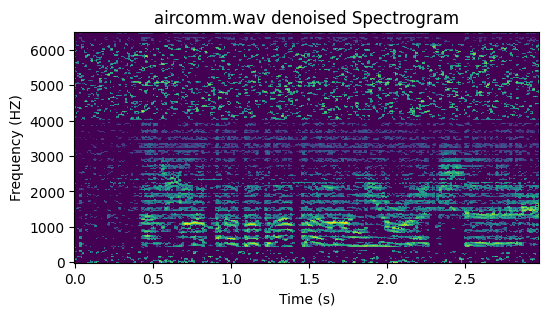

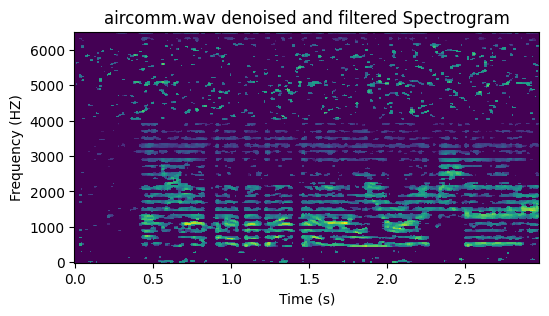

In [6]:
# Working on the aircomm.wav file
fname_ATC = 'aircomm.wav'

fs_ATC, input_ATC = wavfile.read(f'./data/{fname_ATC}')
input_ATC = normalize_signal(input_ATC)
sound(input_ATC, fs_ATC, fname_ATC)

stft_ATC = stft(input_ATC, DFT_SIZE, HOP_SIZE, ZERO_PAD, WINDOW)
if DRAW_GRAPHS:
    plot_stft(stft_ATC, fs_ATC, f"{fname_ATC} Spectrogram")

## The noise in this file is very prominent from 0 to 0.4 seconds. ##

# Isolating the noise
noise = input_ATC[0:int(0.4 * fs_ATC)]
sound(noise, fs_ATC, f"Noise in {fname_ATC}")
denoise(stft_ATC, noise, fs_ATC, 1.5, fname_ATC)

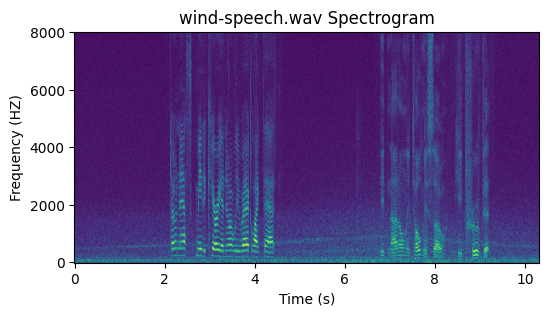

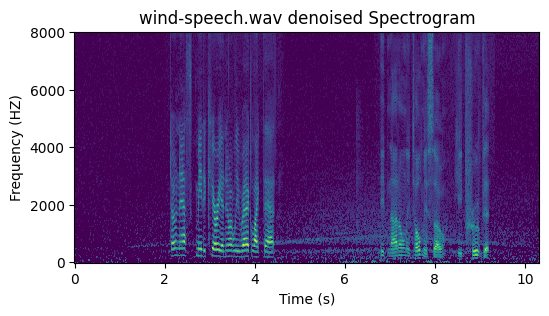

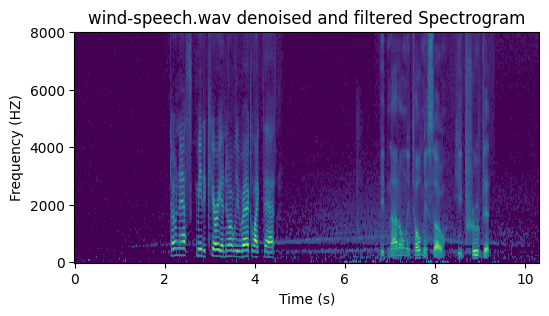

In [7]:
# Working on the wind-speech.wav file
fname_wind = 'wind-speech.wav'

warnings.simplefilter("ignore", category=Warning)
fs_wind, input_wind = wavfile.read(f'./data/{fname_wind}')
input_wind = normalize_signal(input_wind)
sound(input_wind, fs_wind, fname_wind)
warnings.resetwarnings()

stft_wind = stft(input_wind, DFT_SIZE, HOP_SIZE, ZERO_PAD, WINDOW)
if DRAW_GRAPHS:
    plot_stft(stft_wind, fs_wind, f"{fname_wind} Spectrogram")

## The noise in this file is very prominent from 0 to 2 seconds. ##

# Isolating the noise
noise = input_wind[0:2 * fs_wind]
sound(noise, fs_wind, f"Noise in {fname_wind}")
denoise(stft_wind, noise, fs_wind, 1.6, fname_wind)

## Part 2. Implement a Voice Activity Detector (VAD)


For the last sound we have an evolving noise profile, which causes problems since our noise description from the first two seconds isn’t accurate throughout. Because we’re lazy we want to automatically update the noise model and not to select it manually. To do so we need a VAD that lets us know when to gather noise statistics and when to denoise. Do the following:

- Take the square of the input waveform and lowpass filter it (a lot) to get an energy level over time
    - Experiment with the cutoff frequency so that you get a smooth energy-looking function
- Set a threshold over which we seem to have speech in the input
- Implement a real-time spectral subtraction denoiser
    - If an input frame is under threshold, it is noise
    - Keep track of the last few noise frames and their average amplitude will be your noise spectrum
    - If an input is over the threshold it is speech
    - Once you encounter speech perform spectral subtraction with the current noise estimate

In [8]:
# YOUR CODE HERE
raise NotImplementedError()

NotImplementedError: 